In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec
import seaborn as sns
import json
import torch

from bnn_priors.exp_utils import load_samples

sns.set(context="paper", style="whitegrid", font_scale=1.5)
%matplotlib inline

## Define functions

In [2]:
# Adapted from https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

import scipy.stats as st
import warnings
import tqdm
from sklearn.mixture import GaussianMixture

# Create models from data
def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    #DISTRIBUTIONS = [st.cauchy,st.gennorm,st.laplace,st.norm,st.t]
    DISTRIBUTIONS = [st.laplace,st.norm,st.t]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    
    sses = {}

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                sses[distribution.name] = sse

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            f"Failed to fit {distribution}"

    return (best_distribution.name, best_params, sses)


def make_pdf(dist, params, size=1000, start=None, end=None):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    if start is None:
        start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    if end is None:
        end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [3]:
def plot_weightdist(weights, title=None, num_bins=50):
    fig, axes = plt.subplots(ncols=2, figsize=(8,3))
    vmin = np.min([weight for weight in weights_reshaped.values()])
    vmax = np.max([weight for weight in weights_reshaped.values()])
    xlim = (vmin, vmax)
    for (name, weight), ax in zip(weights.items(), axes):
        sns.distplot(weight.flatten(), ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
        gauss_pdf = make_pdf(stats.norm, stats.norm.fit(weight), start=xlim[0], end=xlim[1])
        sns.lineplot(data=gauss_pdf, label="gaussian_fit", ax=ax)
        ax.legend(loc="upper right")
        ax.set_xlim(xlim)
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [4]:
def plot_covariance(weights_reshaped, rowvar, title=None):
    fig = plt.figure(figsize=(9,4))
    grid = gridspec.GridSpec(nrows=1,ncols=3,figure=fig,width_ratios=[20,20,1])
    axes = [plt.subplot(spec) for spec in grid]
    vmin = np.min([np.cov(weight, rowvar=rowvar) for weight in weights_reshaped.values()])
    vmax = np.max([np.cov(weight, rowvar=rowvar) for weight in weights_reshaped.values()])
    for (name, weight), ax in zip(weights_reshaped.items(), axes):
        sns.heatmap(np.cov(weight, rowvar=rowvar), cmap="Blues", ax=ax, vmin=vmin, vmax=vmax, cbar=(name=="empirical"), cbar_ax=axes[2])
        ax.set_xlabel(name)
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [5]:
def plot_covar_offdiagonals(weights_reshaped, rowvar, title=None, num_bins=50):
    fig, axes = plt.subplots(ncols=2, figsize=(8,3))
    vmin = np.min([np.cov(weight, rowvar=rowvar) for weight in weights_reshaped.values()])
    xlim = (vmin,-vmin)
    for (name, weight), ax in zip(weights_reshaped.items(), axes):
        covar = np.cov(weight, rowvar=rowvar)
        offdiagonals = covar[np.where(~np.eye(covar.shape[0],dtype=bool))]
        sns.distplot(offdiagonals, ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
        ax.set_xlim(xlim)
        gauss_pdf = make_pdf(stats.norm, stats.norm.fit(offdiagonals), start=xlim[0], end=xlim[1])
        sns.lineplot(data=gauss_pdf, label="gaussian_fit", ax=ax)
        ax.legend(loc="upper right")
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [6]:
def plot_singular_values(weights_reshaped, title=None, num_bins=10):
    fig, axes = plt.subplots(ncols=2, figsize=(8,3))
    for (name, weight), ax in zip(weights_reshaped.items(), axes):
        _, singvals, _ = np.linalg.svd(weight)
        sns.distplot(singvals, ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [7]:
def generate_all_figures(state_dict, exp_name, cnn=True):
    if cnn:
        num_channels = 4
    else:
        num_channels = 2
    with PdfPages(f"../figures/{exp_name}_weight_distributions.pdf") as pdf:
        for param, weight_values in state_dict.items():
            if "weight_prior.p" in param and len(weight_values.shape) == num_channels:
                layer = param.split("weight_prior.p")[0]
                print(layer)

                weight = weight_values.numpy()
                weight_gaussian = np.random.normal(loc=weight.mean(), scale=weight.std(), size=weight.shape)
                weights = {"gaussian": weight_gaussian, "empirical": weight}
                weights_reshaped = {name : weight.reshape(weight.shape[0], -1) for name, weight in weights.items()}

                fig = plot_weightdist(weights, title=f"{layer}weight_distribution")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covariance(weights_reshaped, False, title=f"{layer}covariance_inputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covariance(weights_reshaped, True, title=f"{layer}covariance_outputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covar_offdiagonals(weights_reshaped, False, title=f"{layer}covar_offdiag_inputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covar_offdiagonals(weights_reshaped, True, title=f"{layer}covar_offdiag_outputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_singular_values(weights_reshaped, title=f"{layer}singular_values")
                pdf.savefig()
                plt.close(fig)
    print("done!")

## Load trained weights

In [8]:
exp_name = "200918_cifar"

In [9]:
samples_file = f"../results/{exp_name}/1/samples.pt"

In [10]:
samples = load_samples(samples_file)

In [11]:
weight = samples['net.10.main.3.weight_prior.p'][-1].numpy()

In [12]:
weight_gaussian = np.random.normal(loc=weight.mean(), scale=weight.std(), size=weight.shape)

In [13]:
weights = {"gaussian": weight_gaussian, "empirical": weight}

In [14]:
weights_reshaped = {name : weight.reshape(weight.shape[0], -1) for name, weight in weights.items()}

## Analyse point-wise distribution

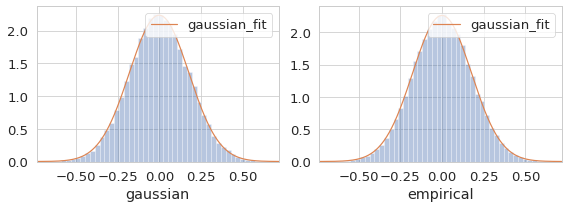

In [15]:
plot_weightdist(weights);

## Analyse weight correlations

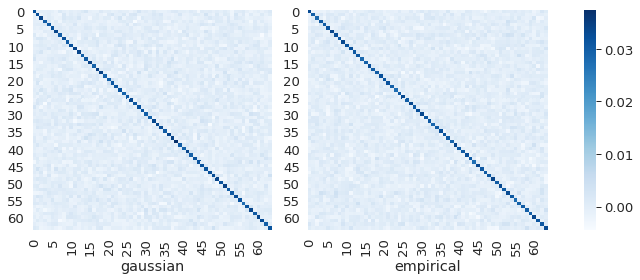

In [16]:
plot_covariance(weights_reshaped, True);

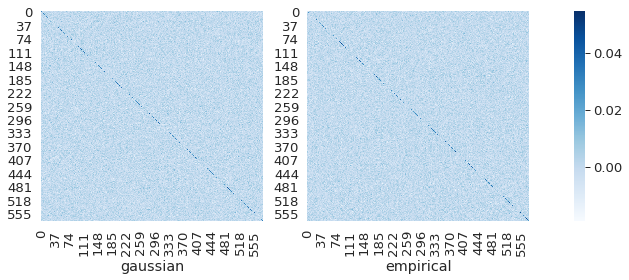

In [17]:
plot_covariance(weights_reshaped, False);

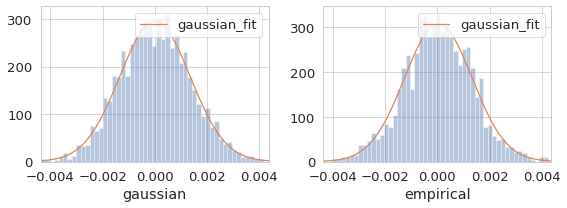

In [18]:
plot_covar_offdiagonals(weights_reshaped, True);

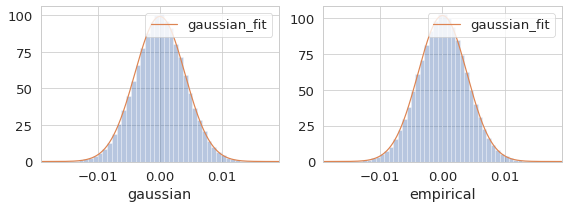

In [19]:
plot_covar_offdiagonals(weights_reshaped, False);

## Analyse singular values

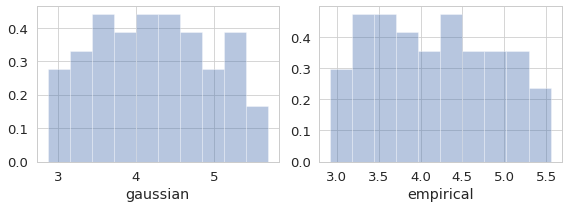

In [20]:
plot_singular_values(weights_reshaped);

## Run analyses for all layers

In [21]:
exp_name = "200918_mnist_cnn"

In [22]:
for config_file in glob(f"../results/{exp_name}/*/config.json"):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    with open(config_file[:-11] + "run.json") as infile:
        result = pd.Series(json.load(infile)["result"], dtype=np.float32)
    run_data = pd.concat([config, result])
    if run_data["weight_prior"] == "improper" and run_data["temperature"] == 0.:
        print(run_data["weight_prior"], run_data["temperature"], run_data["weight_scale"], config_file)

improper 0.0 1.41 ../results/200918_mnist_cnn/20/config.json


In [23]:
samples_file = f"../results/{exp_name}/20/samples.pt"

In [24]:
samples = load_samples(samples_file)

In [25]:
last_sample = {param: weights[-1] for param, weights in samples.items()}  # take the last sample of the chain

In [26]:
generate_all_figures(last_sample, exp_name, cnn=True)

net.1.
net.4.
done!
